In [ ]:
import nltk
import pandas as pd
from nltk import ngrams
from nltk.collocations import QuadgramCollocationFinder  # Import QuadgramCollocationFinder
from nltk.stem import WordNetLemmatizer

In [ ]:
import pandas as pd
file_path = r'app_reviews_with_time_and_version_clue.csv'
df = pd.read_csv(file_path)


In [ ]:
# Display the first few rows of the dataframe
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a32b525d-f8d4-4f68-afff-9cdd4d7de8cb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I can't access analysis to reset my cycle leng...,1,0,164.0,2024-10-20 23:05:36,"Hey, thanks for getting in touch. We’re sorry ...",2024-10-21 07:08:38,164.0
1,99758246-d266-4d43-bd33-9f40a62fb7a7,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,this app is great but it's just really annoyin...,3,0,176.0,2024-10-20 21:54:46,"Hey, thanks for your review. We introduced Clu...",2024-10-21 07:06:28,176.0
2,8b99d9bc-f26c-45e0-933b-0c1918f27050,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It requires money,1,0,NaN,2024-10-20 18:52:05,"Hey, thanks for your review. We introduced Clu...",2024-10-21 07:06:26,NaN
3,a2cf1bea-3067-4c42-bb8e-9a72ce280af7,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Worst app don't use,1,0,177.1,2024-10-20 14:45:12,"Hey, thanks for your review. We’re sorry to he...",2024-10-21 07:06:57,177.1
4,a4b92428-fc5f-4e6d-be94-32c24c06276d,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"It's a good app, but I really don't like that ...",1,0,NaN,2024-10-20 13:39:17,"Hello, we understand you’re disappointed about...",2024-10-21 07:05:14,NaN


In [ ]:
# session 2 Drop rows with missing 'content' as they are not helpful for review analysis
df.dropna(subset=['content'], inplace=True)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import re

# Standardize text data in 'content'
df['content'] = df['content'].str.lower().str.strip()
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove punctuation
import string
df['content'] = df['content'].str.replace('[{}]'.format(string.punctuation), '')

# Remove numbers
df['content'] = df['content'].str.replace('\d+', '')


# Remove mentions
df['content'] = df['content'].replace(r'@\w+', '', regex=True)

# Remove hashtags
df['content'] = df['content'].replace(r'#\w+', '', regex=True)

In [ ]:
# 1. Combine all reviews into one text:
all_text = " ".join(df['content'].tolist())  # Efficiently join all text

In [ ]:
# 2. Tokenize the combined text:
tokens = nltk.word_tokenize(all_text)

In [ ]:
# 3. Remove Stop Words and Punctuation:
cleaned_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in nltk.corpus.stopwords.words('english')]

In [ ]:
# 4. Get frequent bigrams and trigrams (collocations):
bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(cleaned_tokens)
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_words(cleaned_tokens)
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_freq = bigram_finder.ngram_fd.items()
top_10_bigrams = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 4. Reviews with content longer than 80 characters
reviews_long_content = df[df['content'].str.len() > 80]

# 5. Reviews with content longer than 80 characters and have replies
reviews_long_content_replied = reviews_long_content[reviews_long_content['replyContent'].notnull()]

# 6. Reviews with content longer than 80 characters and no replies
reviews_long_content_no_replies = reviews_long_content[reviews_long_content['replyContent'].isnull()]

In [ ]:
# Count the number of reviews in each category
counts = {
    'Total Long Reviews': len(reviews_long_content),
    'Long Reviews with Replies': len(reviews_long_content_replied),
    'Long Reviews without Replies': len(reviews_long_content_no_replies)
}

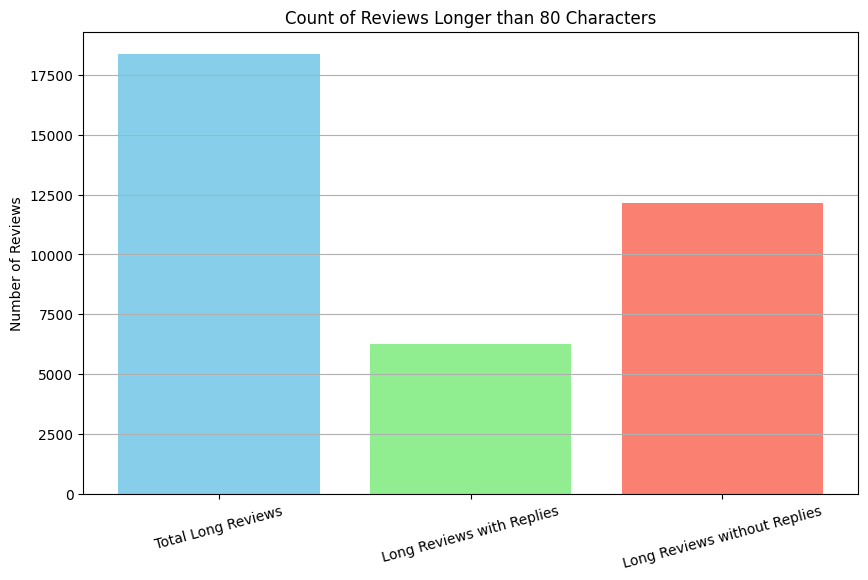

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Count of Reviews Longer than 80 Characters')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=15)
plt.grid(axis='y')

In [ ]:
# TF IDF by comapring with count vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# Bag of Words (BoW) model
# we use  it with filtered data with low scores in reviews aka 1 and 2 only
count_vectorizer = CountVectorizer(max_df=0.40, min_df=2, stop_words='english')
count_matrix = count_vectorizer.fit_transform(df['content'])

In [ ]:
# Get total counts of each word
word_counts = count_matrix.sum(axis=0).A1
word_features = count_vectorizer.get_feature_names_out()

In [ ]:
# Create a DataFrame for visualization
bow_df = pd.DataFrame({'word': word_features, 'count': word_counts}).sort_values(by='count', ascending=False)
print(bow_df.head(20))

          word  count
5877    period  12013
4788      love  11940
3610     great  10053
8233     track   9911
8591       use   9438
3825   helpful   8204
6530    really   8090
2587      easy   7349
2014     cycle   7101
3553      good   6247
248   accurate   6115
8241  tracking   5920
4667      like   5869
1537      clue   5438
8612     using   5059
8596    useful   4523
9033     years   4321
3829     helps   4079
8593      used   4057
998       best   3646


In [ ]:
# 5. Visualization using a box plot for review lengths by score
import seaborn as sns

<ipython-input-28-b8d058327168>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y='review_length', data=df, palette='Set2')


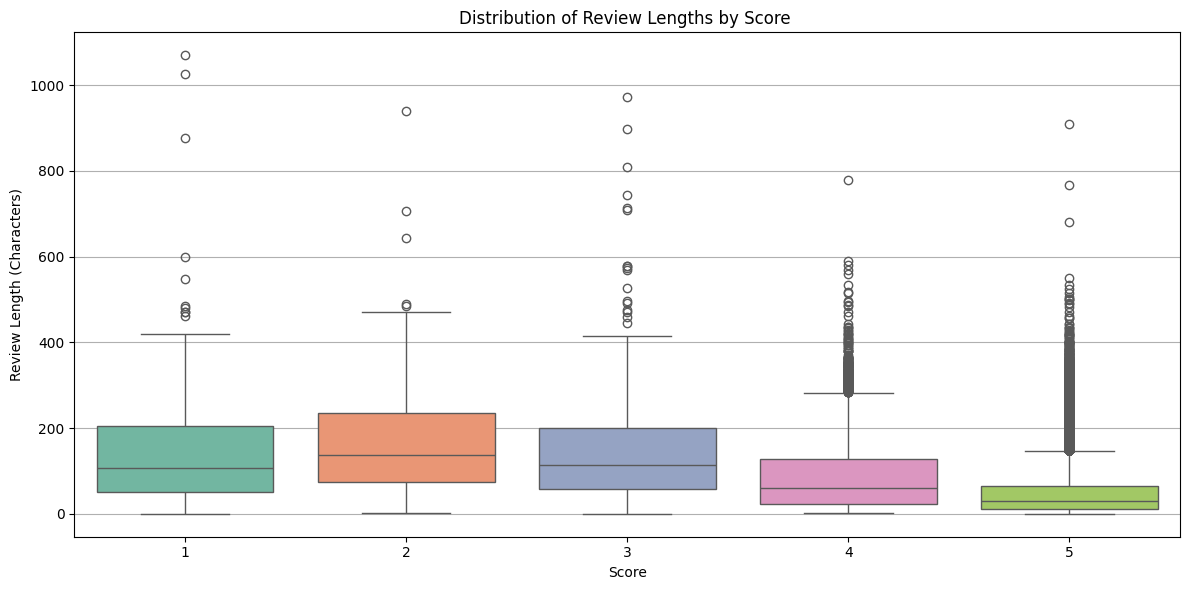

In [ ]:
# Create a new column 'review_length' that contains the length of each review's content
df['review_length'] = df['content'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='score', y='review_length', data=df, palette='Set2')
plt.title('Distribution of Review Lengths by Score ')
plt.xlabel('Score')
plt.ylabel('Review Length (Characters)')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

<ipython-input-30-81e3043ac5d6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=bow_df.head(20), palette='viridis')


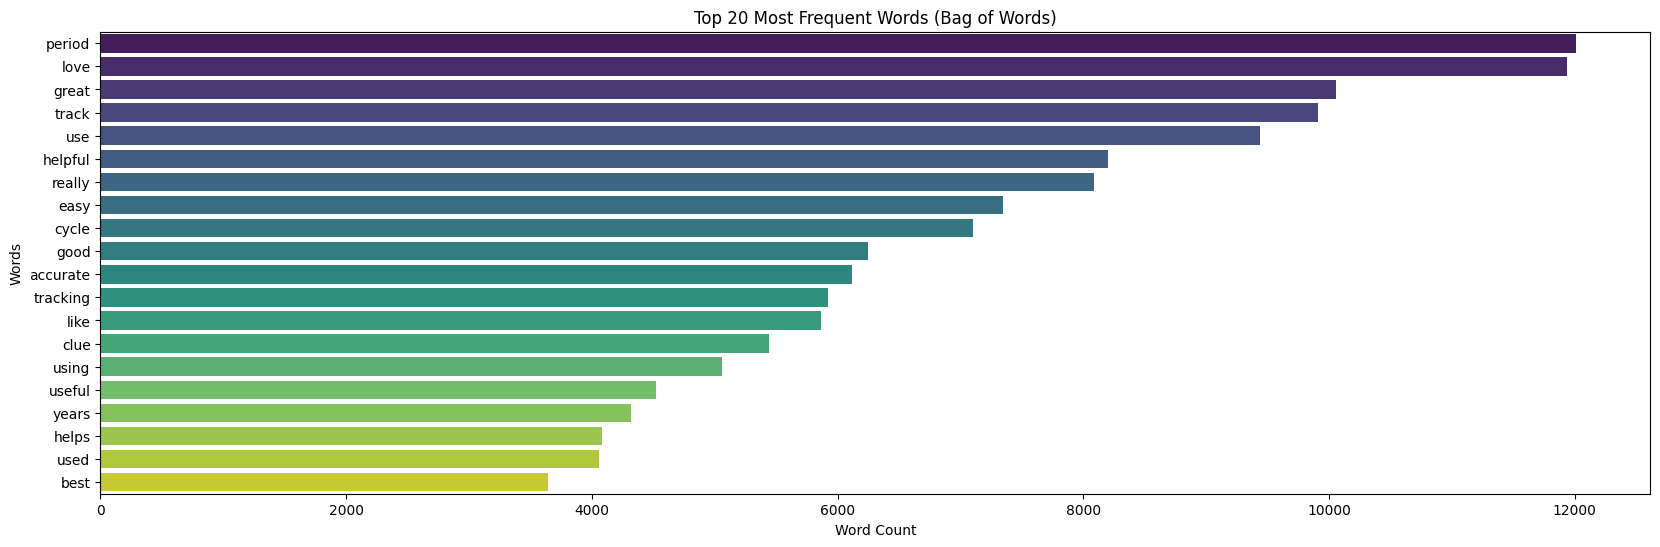

In [ ]:
# Bar plot of top 20 most frequent words in BoW- bag of words
plt.figure(figsize=(20, 6))
sns.barplot(x='count', y='word', data=bow_df.head(20), palette='viridis')
plt.title('Top 20 Most Frequent Words (Bag of Words)')
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['content'])


In [ ]:
# Get mean TF-IDF scores for each word
tfidf_means = tfidf_matrix.mean(axis=0).A1
tfidf_features = tfidf_vectorizer.get_feature_names_out()

In [ ]:
# Create a DataFrame for TF-IDF visualization
tfidf_df = pd.DataFrame({'word': tfidf_features, 'tfidf': tfidf_means}).sort_values(by='tfidf', ascending=False)
print(tfidf_df.head(20))

          word     tfidf
623        app  0.079776
4789      love  0.059733
3611     great  0.052795
3826   helpful  0.052617
3554      good  0.040155
248   accurate  0.033014
8592       use  0.032957
2588      easy  0.032022
5878    period  0.031779
6531    really  0.031149
8597    useful  0.028615
8234     track  0.028422
506    amazing  0.024371
999       best  0.021813
3830     helps  0.020664
2015     cycle  0.019778
8242  tracking  0.018911
4668      like  0.017304
834    awesome  0.016605
8613     using  0.014808


<ipython-input-34-2efdd070f931>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='word', data=tfidf_df.head(20), palette='coolwarm')


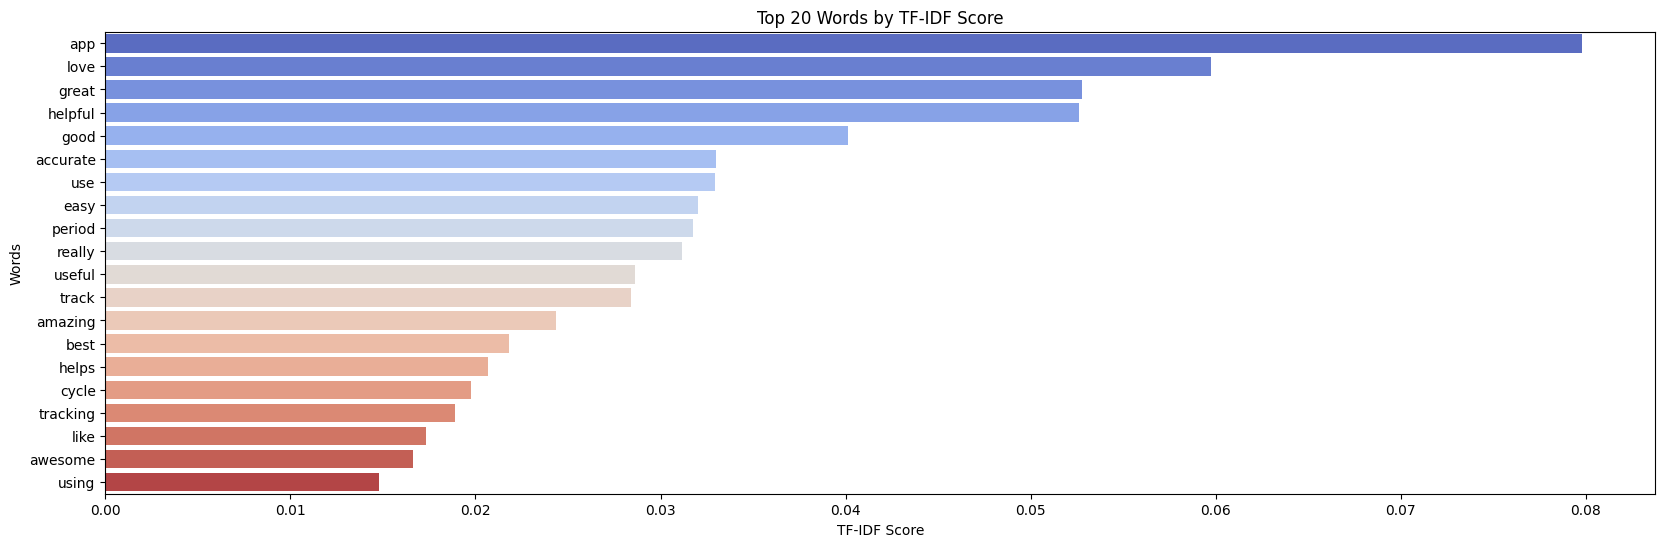

In [ ]:
# Bar plot of top 20 words by TF-IDF score
plt.figure(figsize=(20, 6))
sns.barplot(x='tfidf', y='word', data=tfidf_df.head(20), palette='coolwarm')
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

In [ ]:
#from 4000+ to 1300+ words in bag of words after filtering the bag of words for meaningful words
import pandas as pd
import re
from nltk.corpus import stopwords  # For English stop words (you might need to download: nltk.download('stopwords'))
from nltk.stem import WordNetLemmatizer  # For lemmatization (nltk.download('wordnet'))


In [ ]:
# add language parameter to the function
def refine_bow_df(bow_df, language='english'):
    # Initialize the lemmatizer for the specified language
    lemmatizer = WordNetLemmatizer()
    # Apply lemmatization to the 'word' column
    bow_df['word'] = bow_df['word'].apply(lambda x: lemmatizer.lemmatize(x))
    # Remove stop words from the 'word' column
    stop_words = set(stopwords.words(language))
    bow_df = bow_df[~bow_df['word'].isin(stop_words)]
    return bow_df

In [ ]:
# 1. Remove Numerical Values:
bow_df = bow_df[~bow_df['word'].str.match(r'^\d+$')]  # Remove words that are all digits

In [ ]:
# 3. Remove Short and Long Words (Optional):
min_length = 4  # Adjust as needed
max_length = 15  # Adjust as needed
bow_df = bow_df[(bow_df['word'].str.len() >= min_length) & (bow_df['word'].str.len() <= max_length)]

In [ ]:
# 4. Remove Non-Alphanumeric Characters (Optional, but often useful):
bow_df = bow_df[bow_df['word'].str.isalnum()]  # Keep only alphanumeric words

In [ ]:
# 5. Remove Low-Frequency Words (Optional):
min_frequency = 10 # Adjust as needed
word_counts = bow_df.groupby('word')['count'].sum()  # Sum counts for each word
frequent_words = word_counts[word_counts >= min_frequency].index
bow_df = bow_df[bow_df['word'].isin(frequent_words)]

In [ ]:
# 6. Remove Empty Strings or Duplicates (Important after lemmatization):
bow_df = bow_df[bow_df['word'] != ""]  # Remove empty strings
bow_df = bow_df.drop_duplicates(subset='word') # Remove duplicates that might be created by lemmatization

In [ ]:
refined_bow_df = refine_bow_df(bow_df)  # Pass the DataFrame to the function
len(refined_bow_df)

2919

In [ ]:
# Convert the count_matrix to a DataFrame for better readability
count_matrix_df = pd.DataFrame(count_matrix.toarray(), columns=word_features)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def calculate_cosine_similarity_from_refined(count_matrix_df):
    """Calculates cosine similarity from a refined count matrix."""

    # Convert DataFrame to sparse matrix (important for efficiency)
    count_matrix_sparse = count_matrix_df.values  # Get the NumPy array
    cosine_sim = cosine_similarity(count_matrix_sparse)
    return cosine_sim